# *RECONSTRUCTION VALIDATION*

The Analog Method (AM) is a statistical downscaling method very well suited for reconstruction of climatic time series. The reconstruction can reproduce the climatic characteristics of the local phenomena a certain region, based on the relationship between the large scale and the observed local weather patterns.

To validate the quality of the reconstructions is the important to look how the climatic characteristics are reproduced.

This notebook evaluates the skill of the reconstructions and compares it to the skill of the renalysis looking at the following elements:

- Time series skill (Bias, Heidke Skill Score, SSMSE and Taylor diagrams) for daily, monthly and yearly series
- Seasonality
- Equality of distributions
- Daily indices (Days above zero degree, days of precipitation above threshold, dry spells)

In [1]:
import re
import os
import cfgrib
import datetime
import itertools
import rascal.utils
import rascal.analogs
import rascal.skill_evaluation

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy.stats import percentileofscore

In [2]:
initial_year = 1900
final_year = 2010

station_to_validate = "navacerrada"
variable_to_validate = "PCNR"

groupings = {
    "TMEAN": "mean",
    "TMAX": "mean",
    "TMIN": "mean",
    "PCNR": "hydrosum"
}

reanalysis_variables = {
    "TMEAN": ["SURF_167"],
    "TMAX": ["SURF_167"],
    "TMIN": ["SURF_167"],
    "PCNR": ["SURF_228"]
}

reanalysis_grouping = {
    "TMEAN": "1D_mean",
    "TMAX": "1D_max",
    "TMIN": "1D_min",
    "PCNR": "1D_sum"
}

units = {
    "TMEAN": "[$^\circ$C]",
    "TMAX": "[$^\circ$C]",
    "TMIN": "[$^\circ$C]",
    "PCNR": "[mm]"
}

In [3]:
if variable_to_validate == "PCNR":
    predictor = "SURF_71.162andSURF_72.162-SURF_71.162andSURF_72.162-1"
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    predictor = "925_129-SURF_167-1"

In [4]:
observations_directory = "./data/observations/"
reanalysis_directory = "/home/alvaro/data/NWP/era20c/"
reconstructions_directory = "/".join([".", "output_12h", variable_to_validate, predictor]) + "/"

# 0) LOAD DATA 

### 0.1) STATION DATA

In [5]:
station = rascal.utils.Station(path= observations_directory + station_to_validate + '/')
station_data = station.get_data(variable=variable_to_validate)
station_data.index.name = "time"

### 0.2) REANALYSIS DATA

In [6]:
reanalysis_data_name = "_".join([station.name, variable_to_validate, "ERA20C.csv"])

if os.path.exists(reanalysis_data_name):
    reanalysis_data = pd.read_csv(reanalysis_data_name, index_col=0)
    reanalysis_data.index = pd.to_datetime(reanalysis_data.index)
    
else:
        
    # Years of the reanalysis data
    years = [str(y) for y in range(initial_year, final_year + 1)]

    # The precipitation is a forecast variable in ERA20C, select only one ensemble member
    if variable_to_validate == 'PCNR':
        ensemble_member = 0
    else:
        ensemble_member = None

    # Get the file paths of the reanalysis variable
    secondary_predictor_files = rascal.utils.get_files(
        nwp_path=reanalysis_directory,
        variables=reanalysis_variables[variable_to_validate],
        dates=years,
        file_format=".grib"
    )

    # Get the variable as a time series in the gridpoint of the station
    reanalysis = rascal.analogs.Predictor(
        paths=secondary_predictor_files,
        grouping=reanalysis_grouping[variable_to_validate],
        lat_min=station.latitude,
        lat_max=station.latitude,
        lon_min=station.longitude,
        lon_max=station.longitude,
        mosaic=False,
        number=ensemble_member
    )
    reanalysis_data = reanalysis.data.drop_vars(["latitude", "longitude"]).to_dataframe()
                
    # Change variable name to RASCAL common acronym
    reanalysis_data.columns = [variable_to_validate]

    # Change units
    # Kelvin to Celsius
    if variable_to_validate in ["TMAX", "TMIN", "TMEAN", "TMPA"]:
        reanalysis_data = reanalysis_data-273.1
    # m to mm
    elif variable_to_validate == "PCNR":
        reanalysis_data = reanalysis_data*1000
    
    reanalysis_data.to_csv(reanalysis_data_name)


### 0.3) RECONSTRUCTIONS DATA

### 0.3.1) DAILY RECONSTRUCTIONS

Get all the simulations in the directory as a dataframe

In [7]:
reconstructions_daily = rascal.skill_evaluation.get_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1D',
    grouping=groupings[variable_to_validate]
)

if groupings[variable_to_validate] == "mean":
    station_data_daily = station_data.resample('1D').mean()
    reanalysis_data_daily = reanalysis_data.resample('1D').mean()
elif groupings[variable_to_validate] == "sum" or groupings[variable_to_validate] == "hydrosum" :
    reanalysis_data_daily = reanalysis_data.resample('1D').sum()
    station_data_daily = station_data.resample('1D').sum()

Get the ensemble as a dictionary where the key is the similarity method. Include the reanalysis original data.

In [8]:
daily_ensemble = rascal.skill_evaluation.ensemble_to_dict(reconstructions_daily)
daily_ensemble["reanalysis"] = reanalysis_data_daily

### 0.3.2) MONTHLY RECONSTRUCTIONS

Get all the simulations in the directory as a dataframe

In [9]:
reconstructions_monthly = rascal.skill_evaluation.get_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1m',
    grouping=groupings[variable_to_validate]
)
if groupings[variable_to_validate] == "mean":
    station_data_monthly = station_data.resample('1m').mean()
    reanalysis_data_monthly = reanalysis_data.resample('1m').mean()
elif groupings[variable_to_validate] == "sum" or groupings[variable_to_validate] == "hydrosum" :
    station_data_monthly = station_data.resample('1m').sum()
    reanalysis_data_monthly = reanalysis_data.resample('1m').sum()

Get the ensemble as a dictionary where the key is the similarity method. Include the reanalysis original data.

In [10]:
monthly_ensemble = rascal.skill_evaluation.ensemble_to_dict(reconstructions_monthly)
monthly_ensemble["reanalysis"] = reanalysis_data_monthly

### 0.3.3) YEARLY RECONSTRUCTIONS

Get all the simulations in the directory as a dataframe

In [11]:
reconstructions_yearly = rascal.skill_evaluation.get_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1Y',
    grouping=groupings[variable_to_validate]
)
if groupings[variable_to_validate] == "mean":
    
    station_data_yearly = station_data.resample('1Y').mean()
    reanalysis_data_yearly = reanalysis_data.resample('1Y').mean()
    
elif groupings[variable_to_validate] == "sum":
    
    station_data_yearly = station_data.resample('1Y').sum()
    reanalysis_data_yearly = reanalysis_data.resample('1Y').sum()
    
elif groupings[variable_to_validate] == "hydrosum":
    
    station_data_yearly = rascal.skill_evaluation.get_hydrological_years(station_data)
    station_data_yearly = station_data_yearly.groupby("hydroyear").sum()
    station_data_yearly.index.name = "time"
    
    reanalysis_data_yearly = rascal.skill_evaluation.get_hydrological_years(reanalysis_data)
    reanalysis_data_yearly = reanalysis_data_yearly.groupby("hydroyear").sum()
    reanalysis_data_yearly.index.name = "time"
    
    station_data = station_data.drop(columns=["hydroyear"])

Get the ensemble as a dictionary where the key is the similarity method. Include the reanalysis original data.

In [12]:
yearly_ensemble = rascal.skill_evaluation.ensemble_to_dict(reconstructions_yearly)
yearly_ensemble["reanalysis"] = reanalysis_data_yearly

# 1) DAILY SERIES

### 1.1) Daily time series

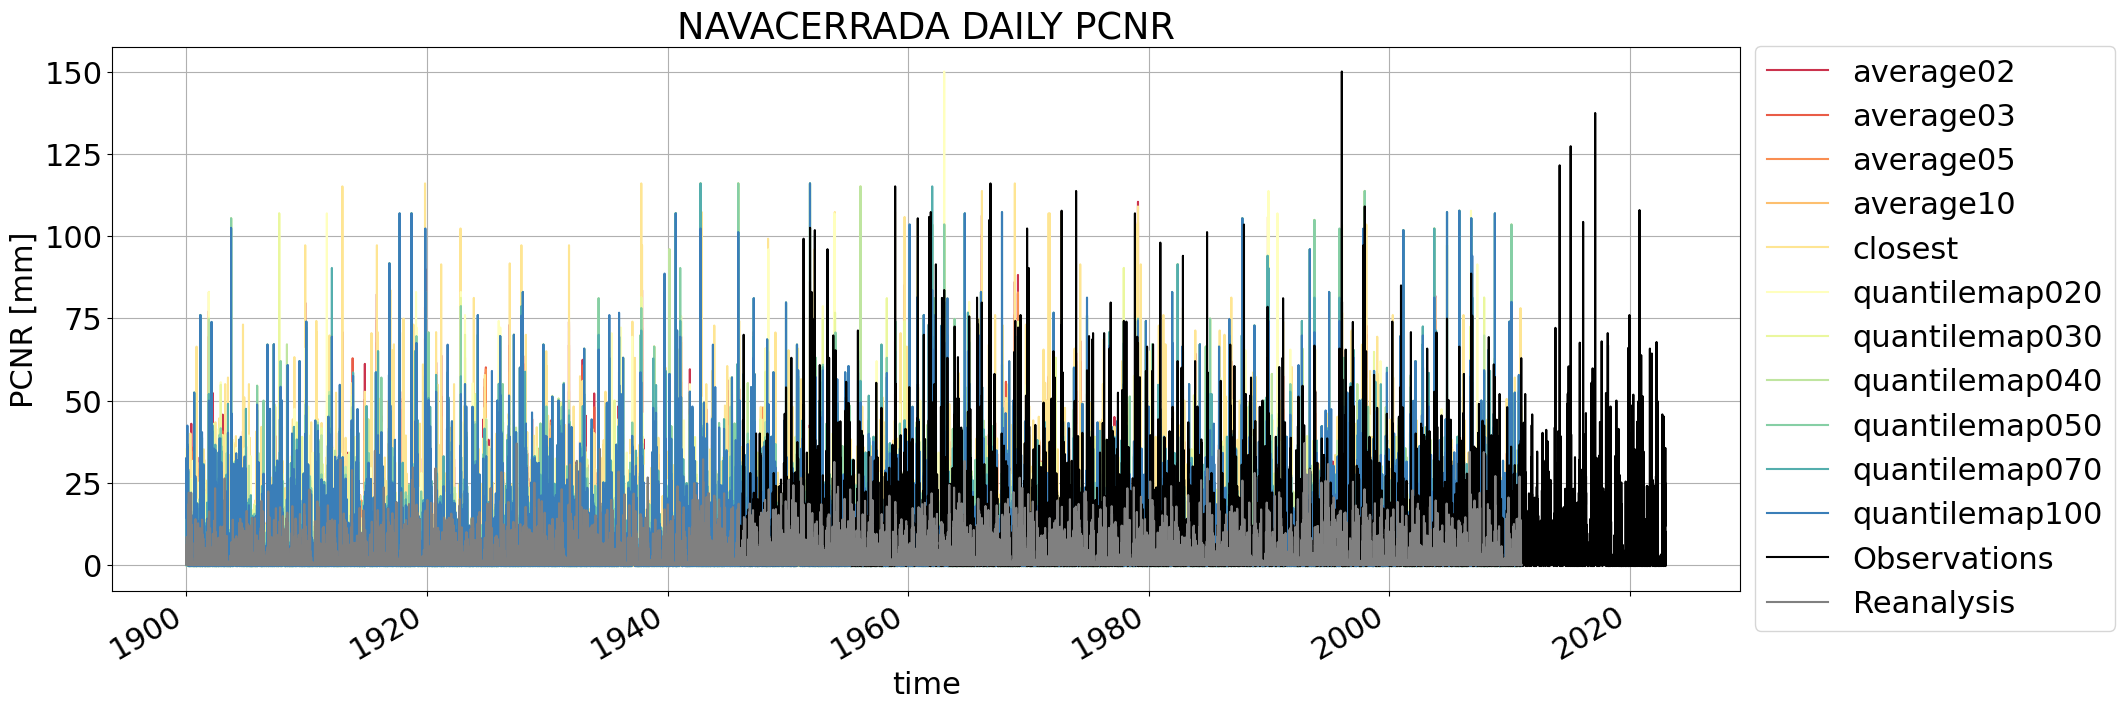

In [13]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(21,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=reconstructions_daily, 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="Spectral"
)
station_data_daily[variable_to_validate].plot(ax=ax, color="black", label="Observations")
reanalysis_data_daily[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.24, 1.03])
# ax.set_xlim(initial_year, final_year)
ax.set_title(station.name.upper() + " DAILY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
ax.grid()
plt.show()

### 1.2) Daily skill table

In [14]:
station_daily_std, daily_skill = rascal.skill_evaluation.get_skill(
    observation=station_data_daily, 
    simulations=daily_ensemble,
    variable=variable_to_validate,
    reference_model=reanalysis_data_daily,
    threshold=1
)

In [15]:
daily_skill

bias       rmse        r2       std     ssmse       hss  \
average02       0.080425   9.165793  0.382423  7.252966   0.11116  0.281203   
average03       0.083914   8.684005  0.417792  6.638374  0.202145    0.2476   
average05        0.11399   8.267378  0.453895  6.040685  0.276865  0.208769   
average10       0.131436   7.885135  0.496347  5.434325  0.342188  0.161617   
closest         0.016731  10.487534  0.317873  8.790849 -0.163671  0.314594   
quantilemap020 -0.022771   8.877955  0.490395  8.295852  0.166109  0.326435   
quantilemap030 -0.013205   8.765558  0.504774  8.302019  0.187089  0.333369   
quantilemap040 -0.021052    8.75465  0.509561  8.367571  0.189111  0.346277   
quantilemap050  -0.01668   8.777041  0.511472   8.43232  0.184958  0.355558   
quantilemap070  0.009102   8.793521  0.508823  8.436479  0.181895  0.365692   
quantilemap100  0.039497    8.74813  0.508351  8.339164  0.190319   0.37828   
reanalysis      2.093817   9.722057  0.028223  3.177141       0.0       0.0   

                      bs  
average02       0.283813  
average03       0.297081  
average05       0.312413  
average10       0.331031  
closest         0.270629  
quantilemap020  0.265953  
quantilemap030  0.263216  
quantilemap040  0.258119  
quantilemap050  0.254454  
quantilemap070  0.250453  
quantilemap100  0.245482  
reanalysis      0.394844

### 1.3) Daily Taylor diagram

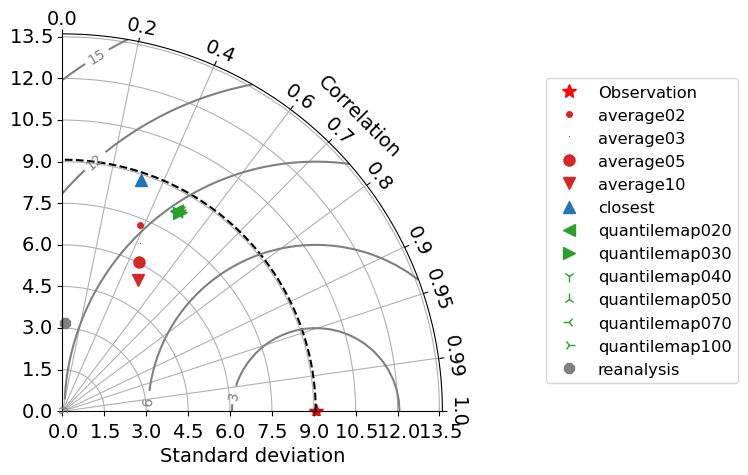

In [16]:
rascal.skill_evaluation.taylor_test(station_daily_std, daily_skill)

# 2) MONTHLY SERIES

### 2.1) Monthly time series

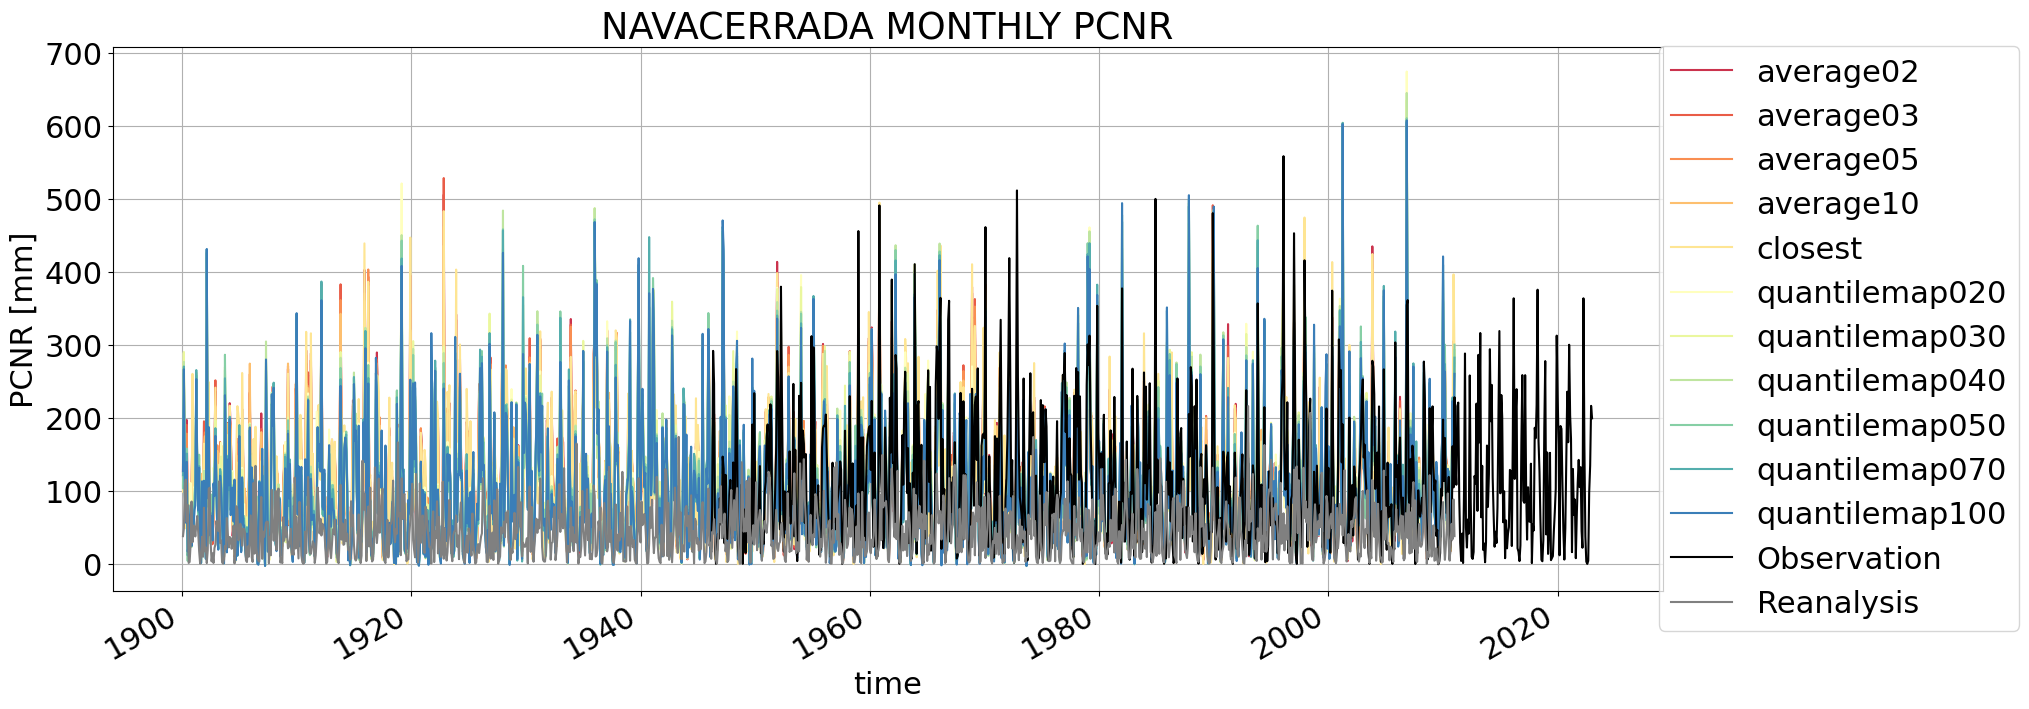

In [17]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=reconstructions_monthly, 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="Spectral"
)
station_data_monthly[variable_to_validate].plot(ax=ax, color="black", label="Observation")
reanalysis_data_monthly[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.24, 1.03])
# ax.set_xlim(years[0], years[-1])
ax.set_title(station.name.upper() + " MONTHLY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
ax.grid()
plt.show()

### 2.2) Monthly skill table

In [18]:
station_monthly_std, monthly_skill = rascal.skill_evaluation.get_skill(
    observation=station_data_monthly, 
    simulations=monthly_ensemble,
    variable=variable_to_validate
)

In [19]:
monthly_skill

bias        rmse        r2        std
average02         2.44792   61.484756  0.761973  81.422204
average03        2.554102   59.088167  0.778573  79.760267
average05        3.469546   57.483789  0.789624  77.650283
average10         4.00053   56.244956   0.79849  75.101247
closest          0.509231   66.132938  0.739492  86.942142
quantilemap020  -0.693077   69.355982  0.710276  86.070045
quantilemap030  -0.401923   68.769015  0.716594  87.014817
quantilemap040  -0.640769    70.30311  0.709407   89.17547
quantilemap050  -0.507692    70.01301   0.71484  90.170934
quantilemap070   0.277051   70.599471  0.710883   90.37434
quantilemap100   1.202179   71.676527  0.703083  90.154655
reanalysis      63.729876  110.343545   0.27833  35.310554

### 2.3) Monthly Taylor diagram

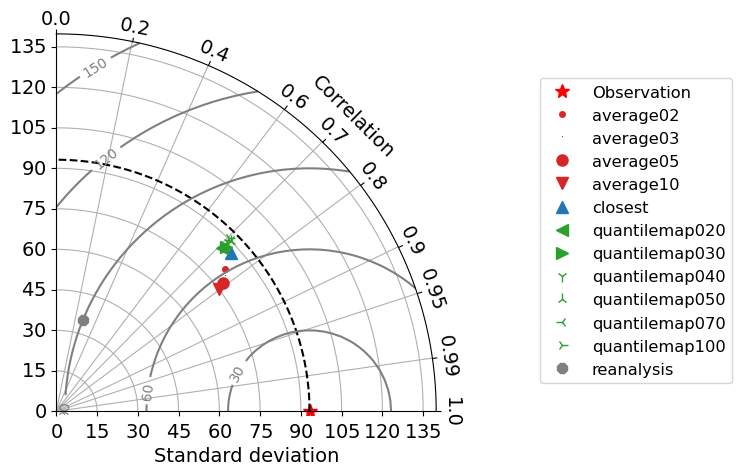

In [20]:
rascal.skill_evaluation.taylor_test(station_monthly_std, monthly_skill)

# 3) YEARLY SERIES

### 3.1) Yearly time series

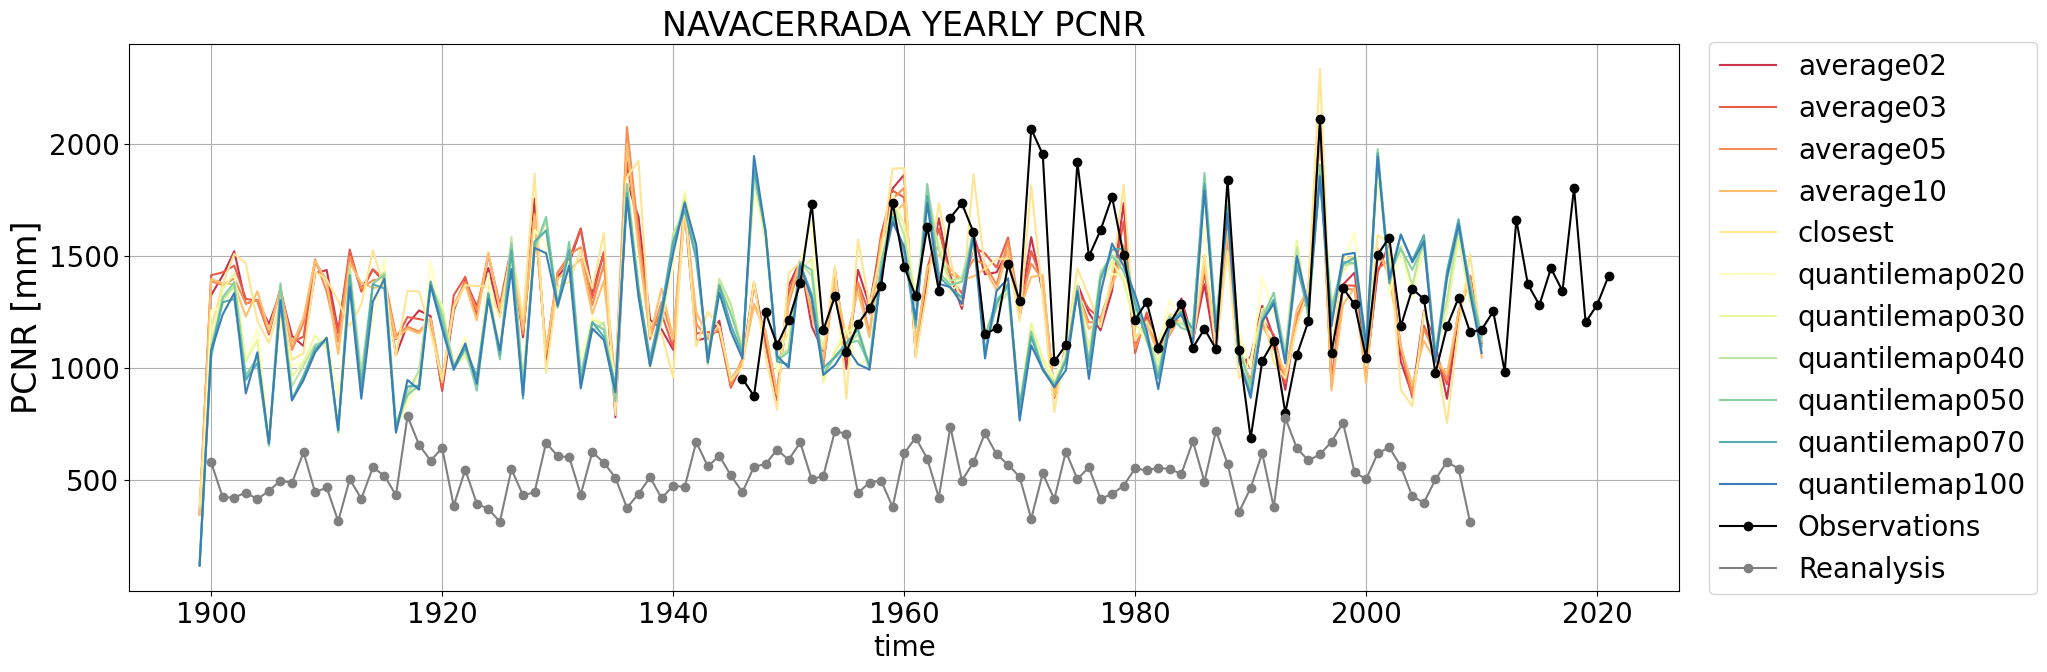

In [21]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,7.1))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=reconstructions_yearly[1:], 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="Spectral"
)
station_data_yearly[variable_to_validate][1:-1].plot(ax=ax, color="black", label="Observations", marker="o")
reanalysis_data_yearly[variable_to_validate][1:-1].plot(ax=ax, color="grey", label="Reanalysis", marker="o")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.24, 1.03])

ax.set_ylabel(variable_to_validate, fontsize=24)
# ax.set_xlim(years[0], years[-1])
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
ax.set_title(station.name.upper() + " YEARLY " + variable_to_validate)
ax.grid()

plt.show()

### 3.2) Yearly skill table

In [22]:
station_yearly_std, yearly_skill = rascal.skill_evaluation.get_skill(
    observation=station_data_yearly, 
    simulations=yearly_ensemble,
    variable=variable_to_validate
)

In [23]:
yearly_skill

bias        rmse        r2         std
average02        27.433995  259.800763  0.626634  254.724777
average03         28.69823  249.696219  0.654727  249.735931
average05        39.763304  244.209283  0.673343  244.272496
average10        45.701323  245.392624  0.671117  232.590442
closest           4.892424   274.45183  0.621291  291.774017
quantilemap020  -14.712121  317.024669  0.420084  280.270695
quantilemap030  -12.639394  323.155502  0.386755  279.748067
quantilemap040  -15.315152  333.992247  0.371928  293.886289
quantilemap050  -12.957576  331.512562    0.3814  296.385694
quantilemap070   -2.748485  333.413421  0.378358  293.683041
quantilemap100    8.606061  340.894316  0.362441  295.376996
reanalysis      755.557422  833.859233 -0.099374  112.797898

### 3.3) Yearly Taylor diagram

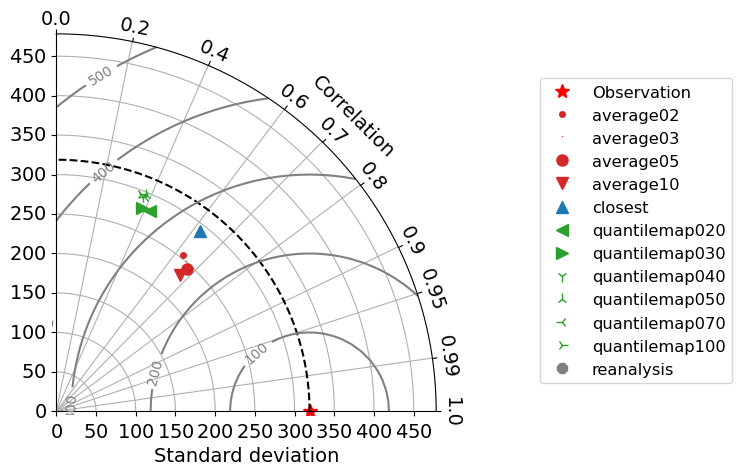

In [24]:
rascal.skill_evaluation.taylor_test(station_yearly_std, yearly_skill)

In [25]:
methods = sorted(list(set(reconstructions_yearly["similarity_method"].values)))
    

In [26]:
error_yearly = []
for method in methods:
    
    method_condition = (reconstructions_yearly["similarity_method"] == method)
    
    # Get individual reconstructions
    reconstruction = reconstructions_yearly.loc[method_condition]
    reconstruction = reconstruction.set_index("time")[variable_to_validate].to_frame()
    error = (reconstruction - station_data_yearly)
    
    error["similarity_method"] = method
    
    error = error.reset_index()
    error_yearly.append(error)

error_yearly = pd.concat(error_yearly, axis=0)
error_yearly = error_yearly.dropna()
error_yearly = error_yearly.reset_index()


error_reanalysis = reanalysis_data_yearly - station_data_yearly

In [27]:
reanalysis_data_yearly


PCNR  observation
time                         
1899  167.462409          NaN
1900  579.028785          NaN
1901  423.278214          NaN
1902  422.386170          NaN
1903  444.333077          NaN
...          ...          ...
2006  503.237905        977.4
2007  582.719681       1185.6
2008  550.795614       1313.2
2009  312.426566       1160.2
2010  320.668639       1171.0

[112 rows x 2 columns]

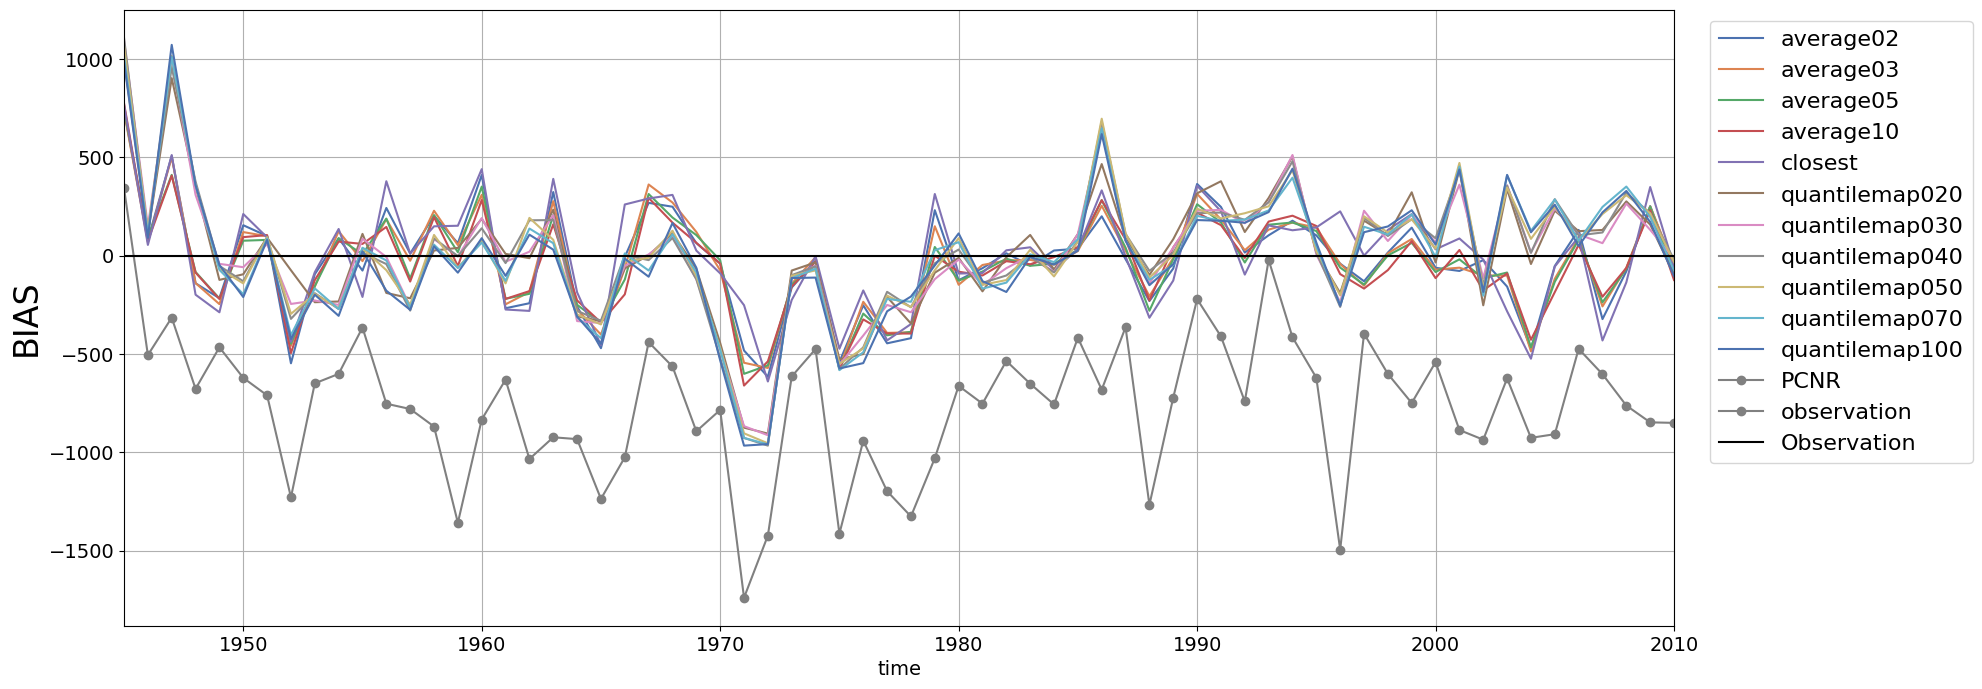

In [28]:
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=error_yearly, 
    x="time", 
    y=variable_to_validate, 
    hue="similarity_method", 
    palette="deep"
)
error_reanalysis.plot(color="grey", ax=ax, label="Reanalysis", marker='o')
ax.axhline(0, color="black", label="Observation")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)
ax.set_ylabel("BIAS", fontsize=24)
ax.set_xlim(error_yearly["time"].values[0], error_yearly["time"].values[-1])

ax.grid()

# 4) SEASONALITY

In [29]:
del daily_ensemble["reanalysis"]

In [30]:
def plot_annual_cycle(reconstructions, observations, reanalysis, variable, grouping="mean"):
    
    plt.rcParams.update({'font.size': 15})

    fig = plt.figure(figsize=(6,6))
    ax = fig.subplots()

    seasonality = pd.DataFrame()

    reanalysis, observations = rascal.skill_evaluation.get_common_data(reanalysis, observations)
        
    for model, reconstruction in reconstructions.items():
     
        reconstruction, observations_i = rascal.skill_evaluation.get_common_data(reconstruction, observations)

        if variable == "PCNR":
            
            reconstruction = reconstruction.resample('1m').sum()
            observations_i = observations_i.resample('1m').sum()
            reanalysis = reanalysis.resample('1m').sum()
            
            var_name = "Precipitation"
        else:
            var_name = variable

        if grouping == "sum":
            reconstruction_monthly = reconstruction.groupby(reconstruction.index.month).sum() 
            observation_monthly = observations_i.groupby(observations_i.index.month).sum()
            reanalysis_monthly = reanalysis.groupby(reanalysis.index.month).sum() 
            
        elif grouping == "mean":
            reconstruction_monthly = reconstruction.groupby(reconstruction.index.month).mean() 
            observation_monthly = observations_i.groupby(observations_i.index.month).mean()
            reanalysis_monthly = reanalysis.groupby(reanalysis.index.month).mean() 
            
        elif grouping == "median":
            reconstruction_monthly = reconstruction.groupby(reconstruction.index.month).median() 
            observation_monthly = observations_i.groupby(observations_i.index.month).median()
            reanalysis_monthly = reanalysis.groupby(reanalysis.index.month).median() 
            
        elif grouping == "std":
            reconstruction_monthly = reconstruction.groupby(reconstruction.index.month).std() 
            observation_monthly = observations_i.groupby(observations_i.index.month).std()
            reanalysis_monthly = reanalysis.groupby(reanalysis.index.month).std()             
            
            var_name = var_name + " Std"
            
        else:
            print("Grouping '" + grouping + "' does not exist")
            exit()
            
        reconstruction_monthly["method"] = model
        reconstruction_monthly.index.name = "month"

        seasonality = pd.concat([seasonality, reconstruction_monthly])

    seasonality = seasonality.reset_index()  

    sns.lineplot(ax=ax, data=seasonality, x="month", y=variable, hue="method", palette="Spectral")
    reanalysis_monthly.columns = ["Reanalysis"]
    reanalysis_monthly.plot(ax=ax, color="grey", marker='*', linewidth=3)
    observation_monthly.columns = ["Observations"]
    observation_monthly.plot(ax=ax, label="Observations", color="black", marker='o', linewidth=3)
    ax.legend(loc="upper right", bbox_to_anchor=[1.6, 1.01], ncol=1)
    ax.set_xticks(range(1, 13))
    ax.set_xlim(1,12)
    fig.suptitle("ANNUAL CYCLE OF " + station.name.upper() + " " + var_name.upper())
    ax.set_ylabel(var_name + " " + units[variable])
    ax.grid()
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    plt.show()


### 4.1) Variable Annual Cycle

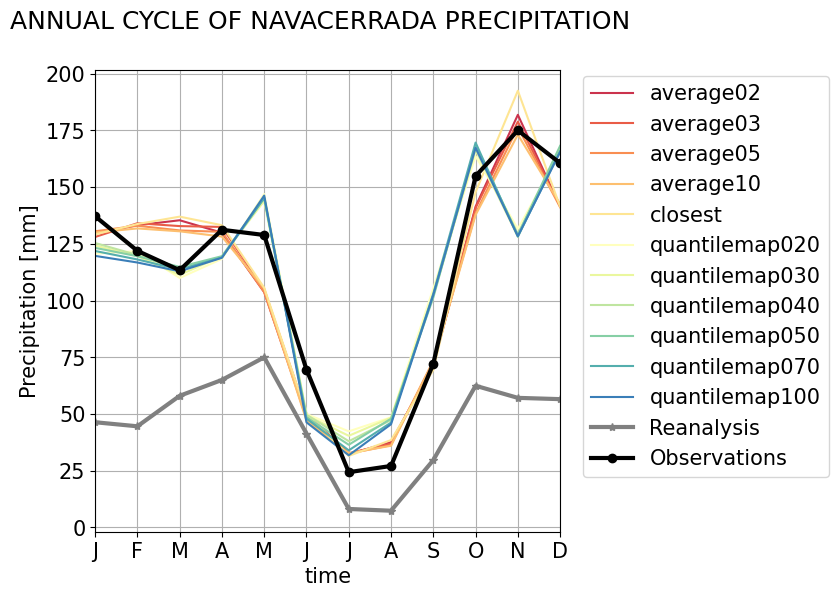

In [31]:
plot_annual_cycle(
    reconstructions=daily_ensemble, 
    observations=station_data_daily, 
    reanalysis=reanalysis_data_daily[variable_to_validate].to_frame(),
    variable=variable_to_validate
)

### 4.2) Variable Standard Deviation Annual Cycle

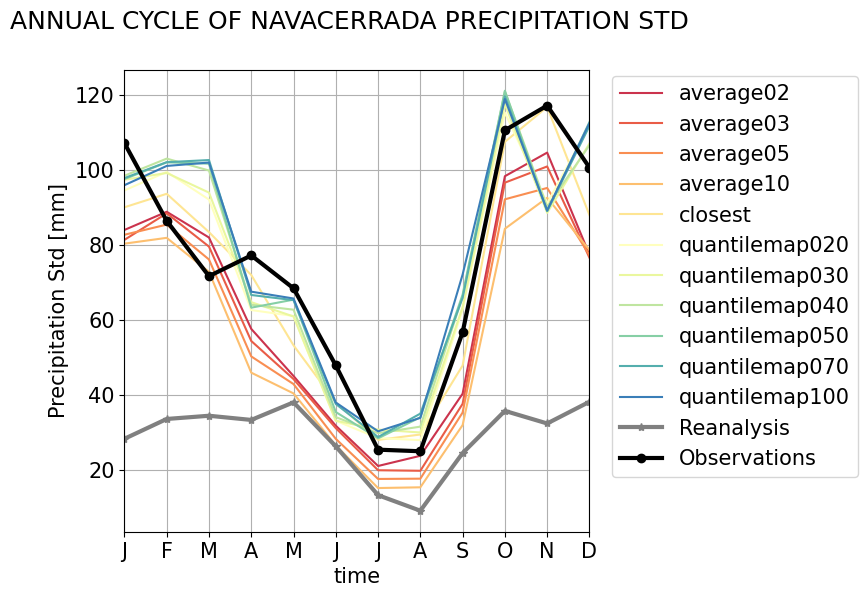

In [32]:
plot_annual_cycle(
    reconstructions=daily_ensemble, 
    observations=station_data_daily, 
    reanalysis=reanalysis_data_daily[variable_to_validate].to_frame(),
    variable=variable_to_validate,
    grouping="std"
)

# 5) DISTRIBUTIONS

### 5.1) Daily Quantile-Quantile Diagram

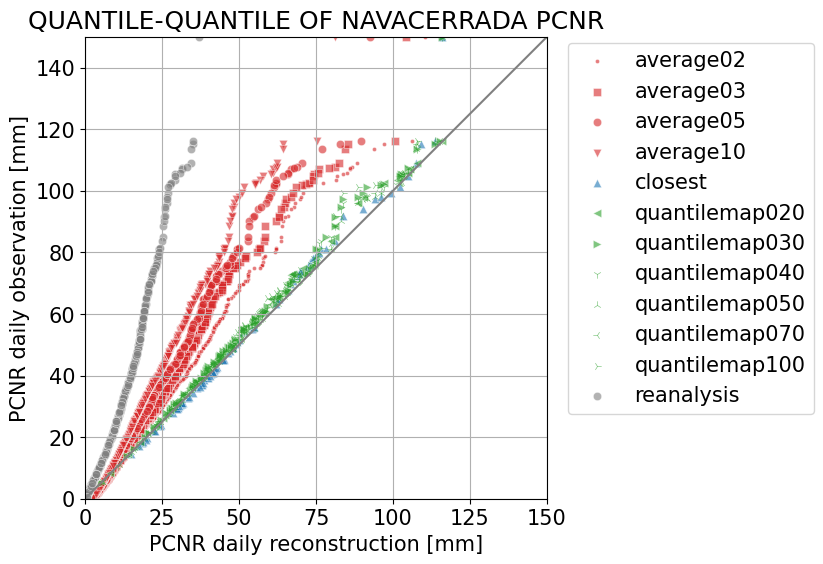

In [33]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()

for i, (model, reconstruction) in enumerate(daily_ensemble.items()):
    
    quantiles = rascal.skill_evaluation.quantile_plots(
        predicted=reconstruction, 
        observed=station_data_daily
    )

    if "closest" in model:
        color = "tab:blue"
    elif "average" in model:
        color = "tab:red"
    elif "quantilemap" in model:
        color = "tab:green"
    else:
        color = "grey"
        
    sns.scatterplot(
        data=quantiles, 
        x='Predicted', 
        y='Observed', 
        ax=ax, 
        alpha=0.6,
        color=color,
        label=model,
        marker=list(Line2D.markers.keys())[i]
    )
        
reanalysis_quantiles = rascal.skill_evaluation.quantile_plots(
        predicted=reanalysis_data_daily, 
        observed=station_data_daily
    )

sns.scatterplot(
        data=reanalysis_quantiles, 
        x='Predicted', 
        y='Observed', 
        ax=ax, 
        alpha=0.6,
        color="grey",
        label="reanalysis"
)
ax.axline([0, 0], [1, 1], color='grey')
ax.set_aspect('equal')
ax.grid()
ax.set_title("QUANTILE-QUANTILE OF " + station.name.upper() + " " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " daily observation " + units[variable_to_validate])
ax.set_xlabel(variable_to_validate + " daily reconstruction " + units[variable_to_validate])
ax.legend(loc="upper right", bbox_to_anchor=[1.6, 1.01], ncol=int(np.ceil(len(daily_ensemble)/20)))

if variable_to_validate == "PCNR":
    ax.set_ylim(0, 150)
    ax.set_xlim(0, 150)

# 6) INDICES

In [34]:
def get_days_above_threshold(ensemble, variable, threshold, freq, inverse=False):

    ensemble_days_above_threshold = pd.DataFrame()

    for model, data in ensemble.items():
     
        days_above_threshold = data.copy()
        
        if inverse: 
            days_above_threshold[variable][data[variable] > threshold] = 0
            days_above_threshold[variable][data[variable] <= threshold] = 1
        else:
            days_above_threshold[variable][data[variable] > threshold] = 1
            days_above_threshold[variable][data[variable] <= threshold] = 0
    
        monthly_days_above_threshold = days_above_threshold[variable].resample(freq).sum().to_frame()
        monthly_days_above_threshold["model"] = model
    
        ensemble_days_above_threshold = pd.concat([ensemble_days_above_threshold, monthly_days_above_threshold], axis=0)

    ensemble_days_above_threshold = ensemble_days_above_threshold.reset_index()
    
    return ensemble_days_above_threshold


### 6.1) Monthly days above certain threshold 

In [47]:
if variable_to_validate == "PCNR":
    threshold = 1
    inverse = False
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    threshold = 0
    inverse = True

extended_daily_ensemble = daily_ensemble.copy()     
extended_daily_ensemble["observations"] = station_data_daily
extended_daily_ensemble["reanalysis"] = reanalysis_data_daily


days_above_threshold = get_days_above_threshold(
    ensemble=extended_daily_ensemble, 
    variable=variable_to_validate,
    threshold=threshold, 
    freq="m",
    inverse=inverse
)


/tmp/ipykernel_67175/1578820240.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_above_threshold[variable][data[variable] > threshold] = 1
/tmp/ipykernel_67175/1578820240.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_above_threshold[variable][data[variable] <= threshold] = 0
/tmp/ipykernel_67175/1578820240.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_above_threshold[variable][data[variable] > threshold

In [48]:
days_above_threshold

time  PCNR       model
0     1900-01-31  20.0   average02
1     1900-02-28  26.0   average02
2     1900-03-31  16.0   average02
3     1900-04-30   9.0   average02
4     1900-05-31  17.0   average02
...          ...   ...         ...
16903 2010-08-31   3.0  reanalysis
16904 2010-09-30   8.0  reanalysis
16905 2010-10-31   8.0  reanalysis
16906 2010-11-30  12.0  reanalysis
16907 2010-12-31   7.0  reanalysis

[16908 rows x 3 columns]

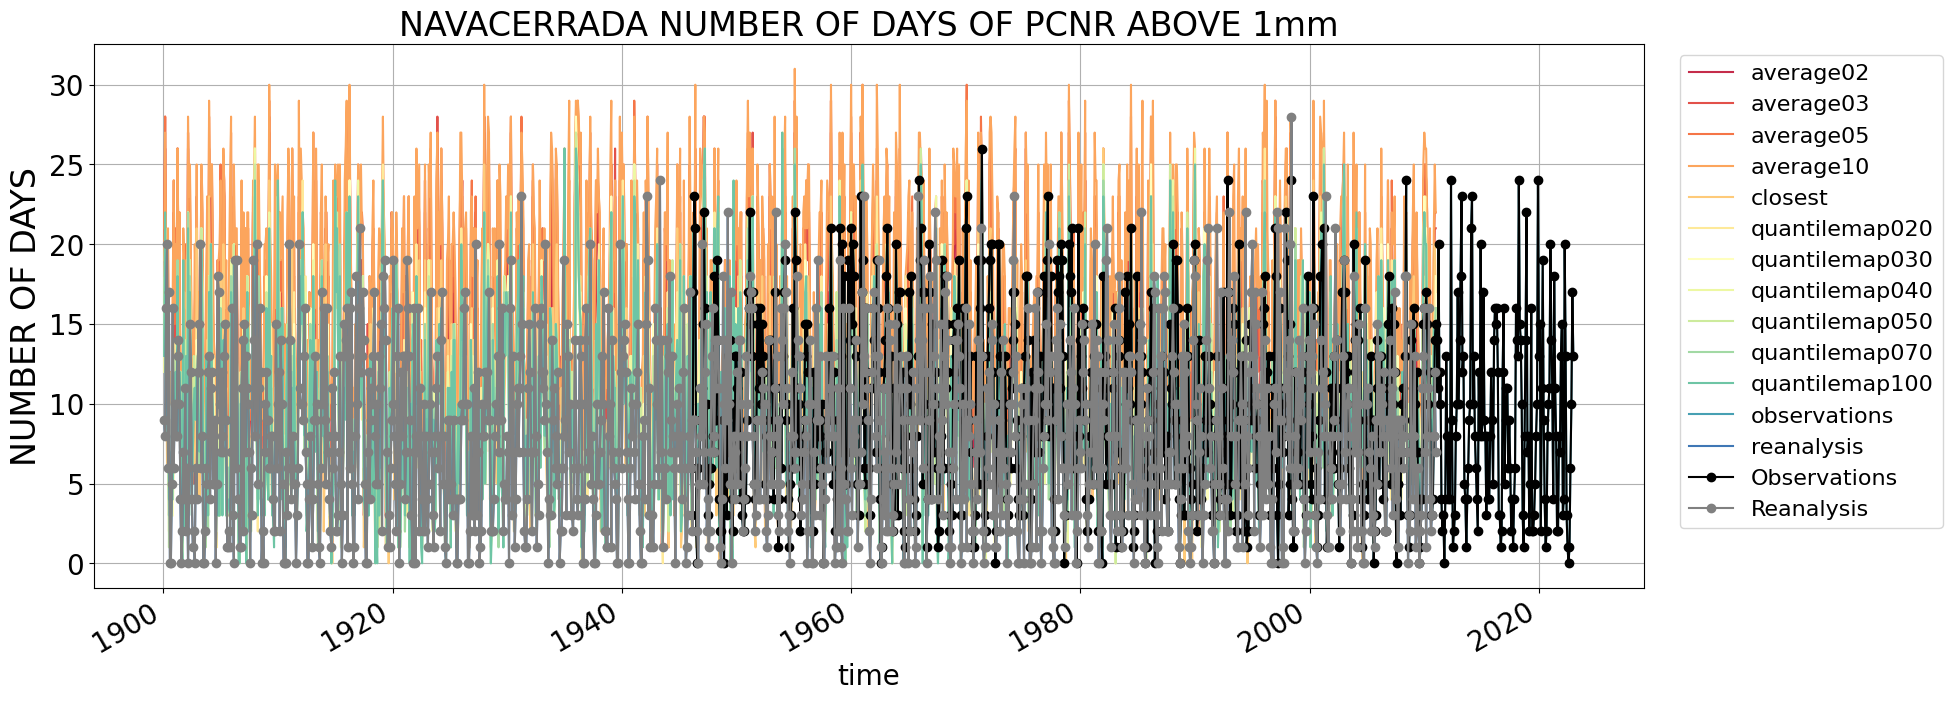

In [49]:
if inverse:
   threshold_label = "BELOW " + str(threshold) + units[variable_to_validate].replace("[", "").replace("]", "") 
else:
   threshold_label = "ABOVE " + str(threshold) + units[variable_to_validate].replace("[", "").replace("]", "")  

plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=days_above_threshold, 
    x="time", 
    y=variable_to_validate, 
    hue="model", 
    palette="Spectral"
)
days_above_threshold.loc[days_above_threshold["model"] == "observations"].set_index("time")[variable_to_validate].plot(ax=ax, color="black", label="Observations", marker="o")
days_above_threshold.loc[days_above_threshold["model"] == "reanalysis"].set_index("time")[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis", marker="o")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)

ax.set_ylabel("NUMBER OF DAYS", fontsize=24)
ax.set_title(station.name.upper() + " NUMBER OF DAYS OF " + variable_to_validate + " " + threshold_label)
ax.grid()


plt.show()

In [50]:
days_above_threshold = days_above_threshold.rename(columns={"model": "similarity_method"})
threshold_series = rascal.skill_evaluation.ensemble_to_dict(days_above_threshold.loc[days_above_threshold["similarity_method"] != "observations"])

threshold_monthly_std, threshold_monthly_skill = rascal.skill_evaluation.get_skill(
    observation=days_above_threshold.loc[days_above_threshold["similarity_method"] == "observations"].set_index("time")[variable_to_validate].to_frame(), 
    simulations=threshold_series,
    variable=variable_to_validate
)

In [51]:
threshold_monthly_skill

bias      rmse        r2       std
average02      -2.707692  4.538722  0.803579  5.987479
average03          -4.15  5.548273  0.809088  6.193543
average05      -5.621795  6.791492  0.803435  6.338609
average10       -7.29359  8.325355  0.791264  6.489306
closest         0.167949  3.544045  0.796081  5.423694
quantilemap020  -1.10641  4.227656  0.726692  5.379741
quantilemap030 -0.951282  4.237803  0.725308  5.455899
quantilemap040 -0.817949  4.216573    0.7255  5.490694
quantilemap050 -0.660256  4.155781  0.731887  5.550794
quantilemap070 -0.532051  4.046366  0.744632  5.585057
quantilemap100 -0.379487  4.038596  0.747198  5.680367
reanalysis      1.264103  6.419322  0.380863  5.571475

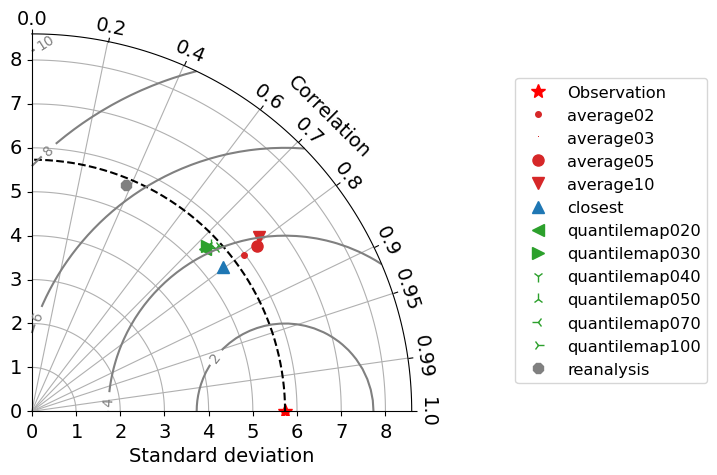

In [52]:
rascal.skill_evaluation.taylor_test(threshold_monthly_std, threshold_monthly_skill)

### 6.2) Yearly days above certain threshold 

In [53]:
days_above_threshold = get_days_above_threshold(
    ensemble=extended_daily_ensemble, 
    variable=variable_to_validate,
    threshold=threshold, 
    freq="Y",
    inverse=inverse
)


/tmp/ipykernel_67175/1578820240.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_above_threshold[variable][data[variable] > threshold] = 1
/tmp/ipykernel_67175/1578820240.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_above_threshold[variable][data[variable] <= threshold] = 0
/tmp/ipykernel_67175/1578820240.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_above_threshold[variable][data[variable] > threshold

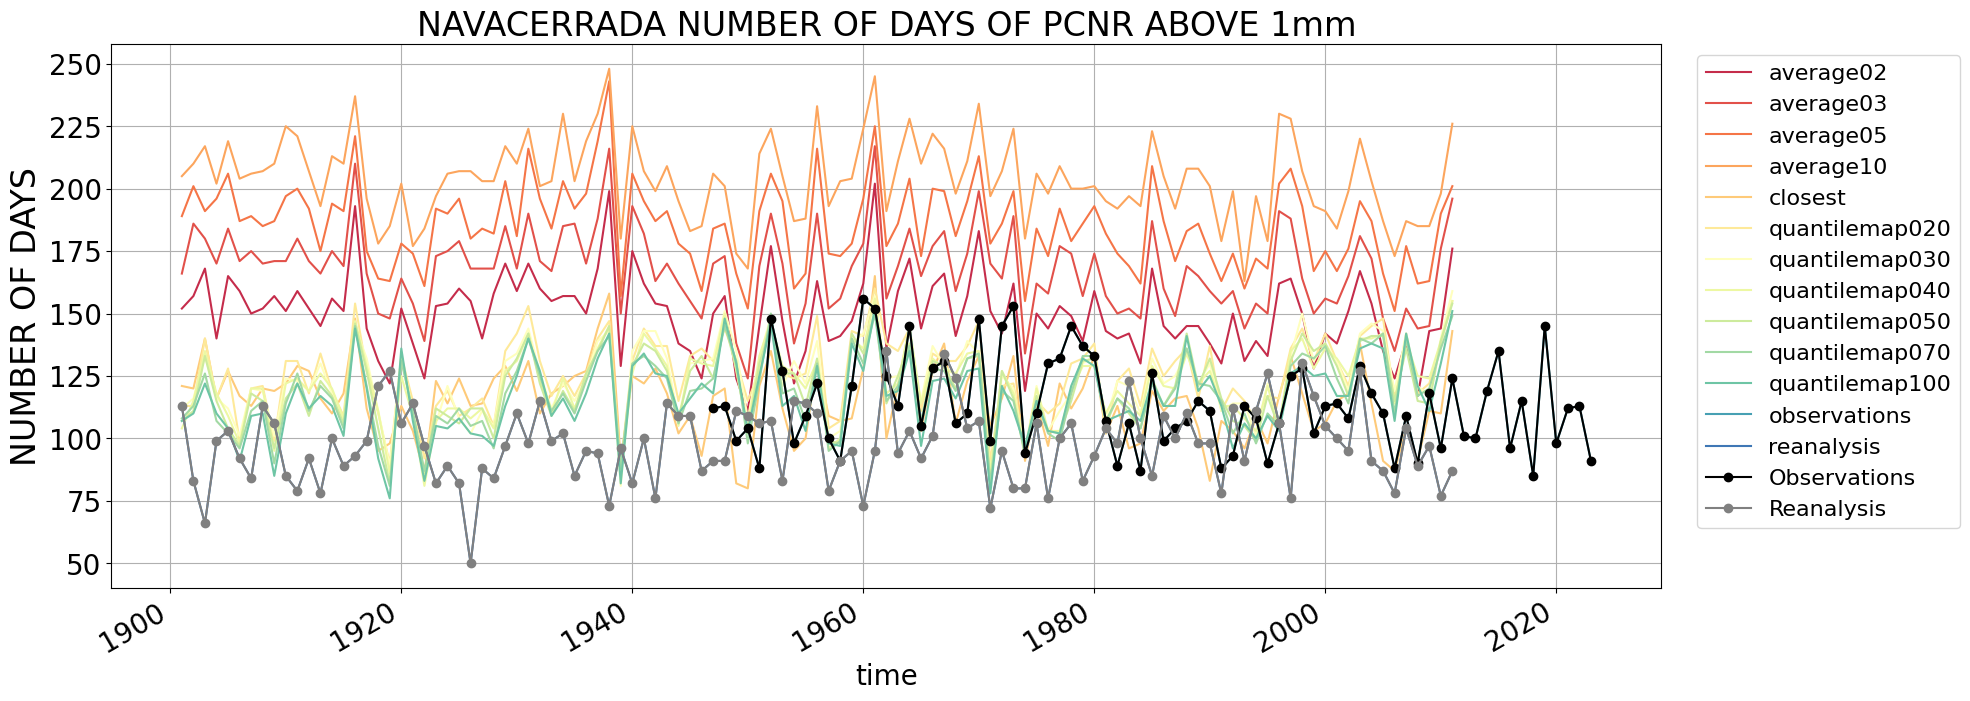

In [54]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,8))
ax = fig.subplots()
sns.lineplot(
    ax=ax, 
    data=days_above_threshold, 
    x="time", 
    y=variable_to_validate, 
    hue="model", 
    palette="Spectral"
)
days_above_threshold.loc[days_above_threshold["model"] == "observations"].set_index("time")[variable_to_validate].plot(ax=ax, color="black", label="Observations", marker="o")
days_above_threshold.loc[days_above_threshold["model"] == "reanalysis"].set_index("time")[variable_to_validate].plot(ax=ax, color="grey", label="Reanalysis", marker="o")
ax.legend(loc='upper right', ncol=1, bbox_to_anchor=[1.2, 1], fontsize=16)

ax.set_ylabel("NUMBER OF DAYS", fontsize=24)
ax.set_title(station.name.upper() + " NUMBER OF DAYS OF " + variable_to_validate + " " + threshold_label)
ax.grid()


plt.show()

In [55]:
days_above_threshold = days_above_threshold.rename(columns={"model": "similarity_method"})
threshold_series = rascal.skill_evaluation.ensemble_to_dict(days_above_threshold.loc[days_above_threshold["similarity_method"] != "observations"])

threshold_yearly_std, threshold_yearly_skill = rascal.skill_evaluation.get_skill(
    observation=days_above_threshold.loc[days_above_threshold["similarity_method"] == "observations"].set_index("time")[variable_to_validate].to_frame(), 
    simulations=threshold_series,
    variable=variable_to_validate
)

In [56]:
threshold_yearly_skill

bias       rmse        r2        std
average02      -32.492308  35.293495  0.683335  16.147954
average03           -49.8  51.919612  0.658785  16.747396
average05      -67.461538  68.909193  0.669426  16.726642
average10      -87.523077  88.842904  0.621384  16.337564
closest          2.015385  14.445122  0.658585  15.578246
quantilemap020 -13.276923  21.168554  0.505497  15.128511
quantilemap030 -11.415385  21.329647  0.418771   15.43487
quantilemap040  -9.815385  20.182247  0.434526  15.103571
quantilemap050  -7.923077  19.728542  0.424437  15.428716
quantilemap070  -6.384615  18.734173  0.448057  15.130297
quantilemap100  -4.553846  18.166749  0.445875  15.531965
reanalysis      15.169231  28.378757 -0.032642  15.191759

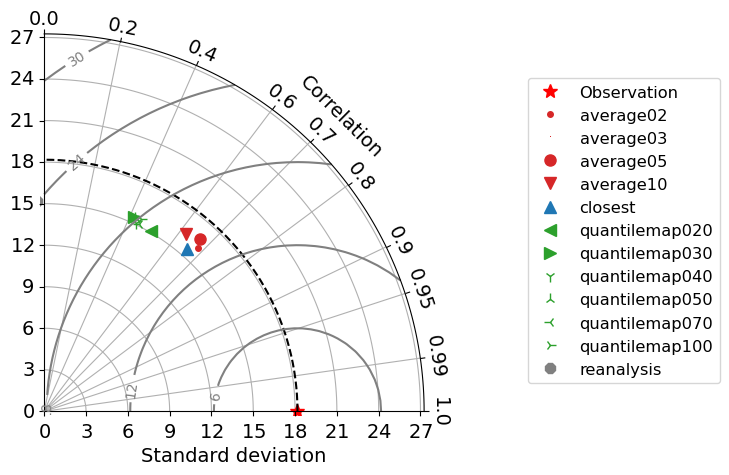

In [57]:
rascal.skill_evaluation.taylor_test(threshold_yearly_std, threshold_yearly_skill)

### 6.3) Seasonal Skill Table

/home/alvaro/SNOWCAST/SeriesReconstruction/rascal/skill_evaluation.py:1147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation['observation'] = observation.copy()
/home/alvaro/SNOWCAST/SeriesReconstruction/rascal/skill_evaluation.py:1147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation['observation'] = observation.copy()
/home/alvaro/SNOWCAST/SeriesReconstruction/rascal/skill_evaluation.py:1147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

/home/alvaro/SNOWCAST/SeriesReconstruction/rascal/skill_evaluation.py:1147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation['observation'] = observation.copy()
/home/alvaro/SNOWCAST/SeriesReconstruction/rascal/skill_evaluation.py:1147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation['observation'] = observation.copy()
/home/alvaro/SNOWCAST/SeriesReconstruction/rascal/skill_evaluation.py:1147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

/home/alvaro/SNOWCAST/SeriesReconstruction/rascal/skill_evaluation.py:1147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation['observation'] = observation.copy()
/home/alvaro/SNOWCAST/SeriesReconstruction/rascal/skill_evaluation.py:1147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulation['observation'] = observation.copy()
/home/alvaro/SNOWCAST/SeriesReconstruction/rascal/skill_evaluation.py:1147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

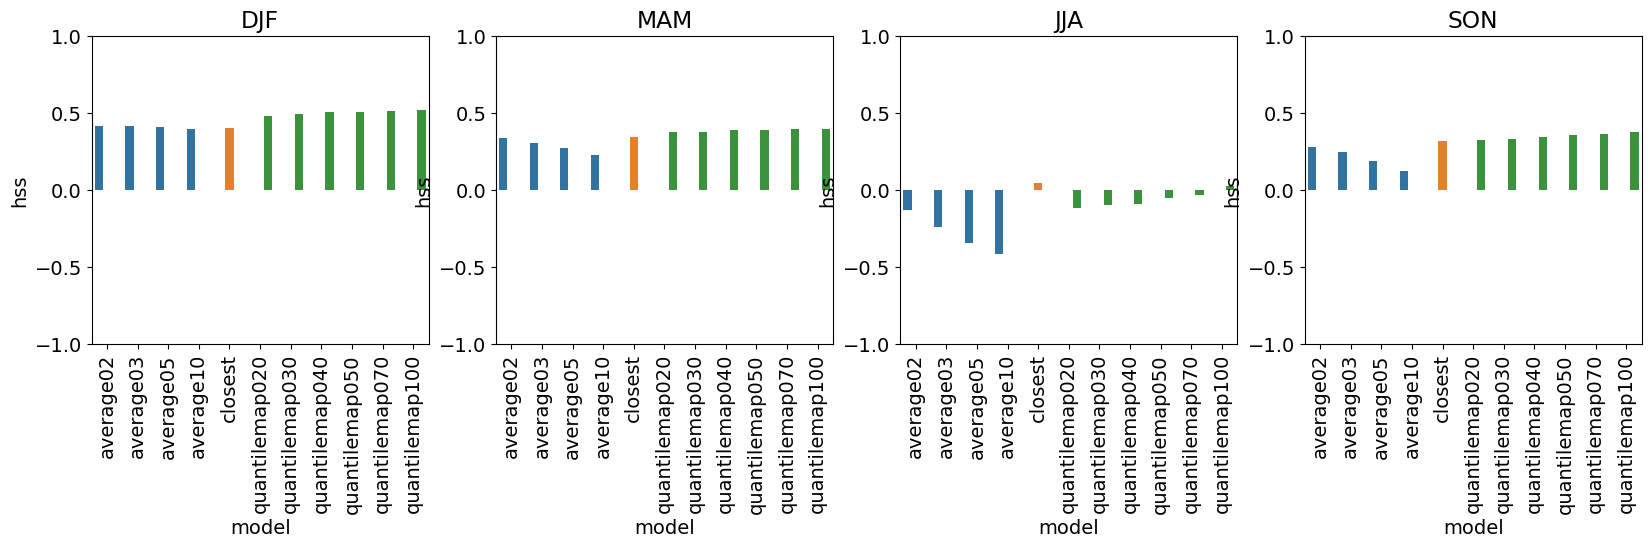

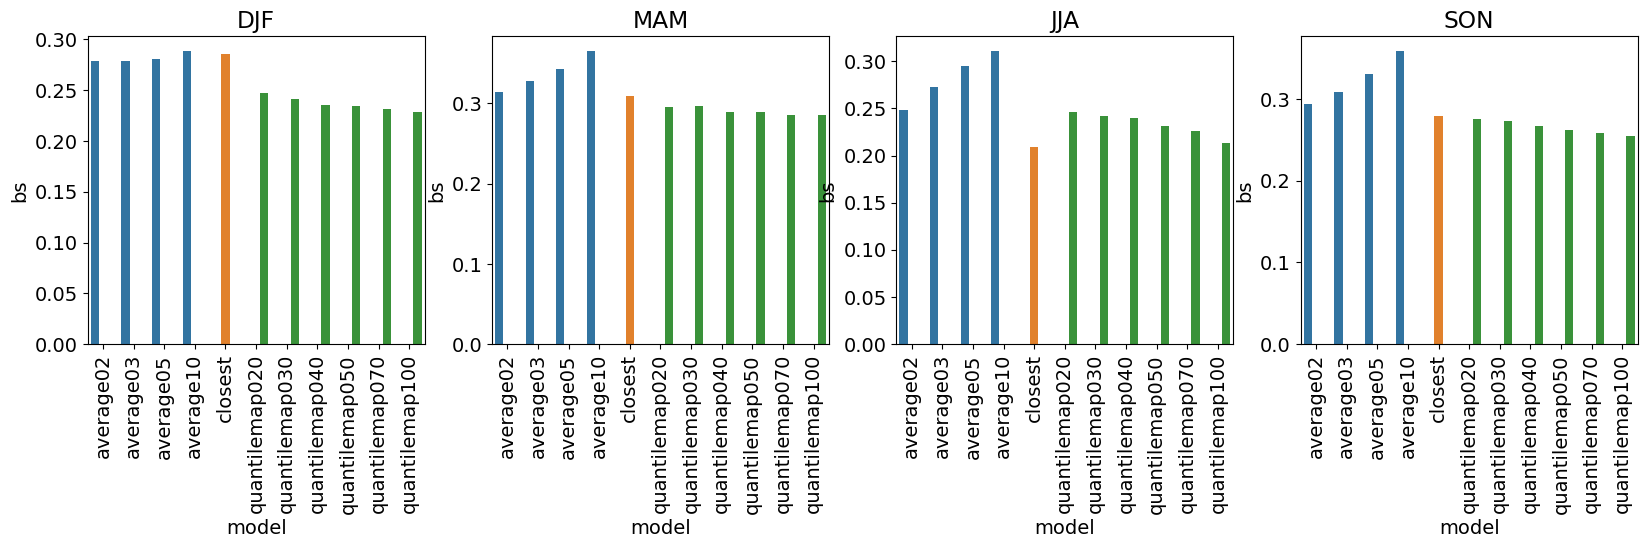

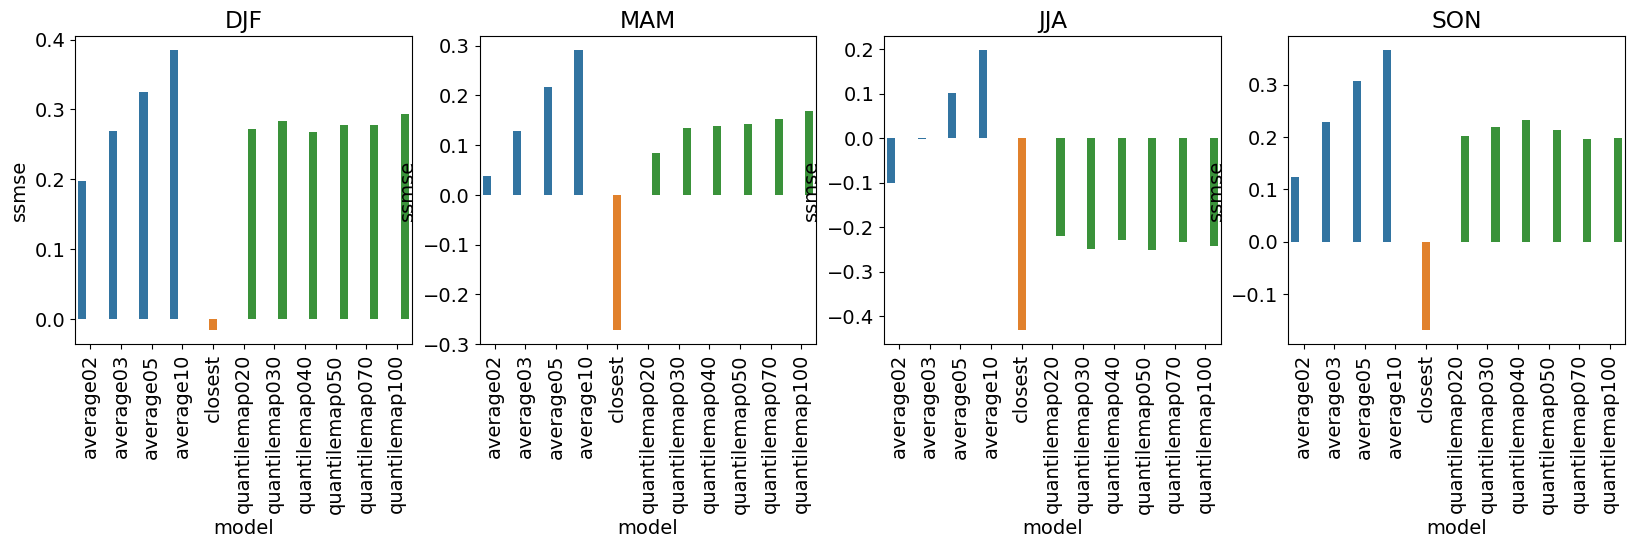

In [58]:
seasons = [
    [12, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [9, 10, 11]
]
seasons_name = [
    "DJF",
    "MAM",
    "JJA",
    "SON"
]


fig1 = plt.figure(figsize=(20, 4))
ax1 = fig1.subplots(1, 4)

fig2 = plt.figure(figsize=(20, 4))
ax2 = fig2.subplots(1, 4)

fig3 = plt.figure(figsize=(20, 4))
ax3 = fig3.subplots(1, 4)

for i, season in enumerate(seasons):
    seasonal_observation = station_data_daily.loc[station_data_daily.index.month.isin(season)]
    seasonal_reanalysis = reanalysis_data_daily.loc[reanalysis_data_daily.index.month.isin(season)]
    seasonal_ensemble = {}
    for k, v in daily_ensemble.items():
        seasonal_ensemble[k] = v.loc[v.index.month.isin(season)]

    _, seasonal_skill = rascal.skill_evaluation.get_skill(
        observation=seasonal_observation, 
        simulations=seasonal_ensemble,
        variable=variable_to_validate,
        reference_model=seasonal_reanalysis,
        threshold=threshold
    )
    
    seasonal_skill.index.name = "model"
    seasonal_skill = seasonal_skill.reset_index()
    seasonal_skill["method"] = seasonal_skill["model"].apply(lambda x: re.sub(r'[0-9]', '', x))

    
    p1 = sns.barplot(data=seasonal_skill, x="model", y="hss", ax=ax1[i], hue="method")
    p1.set_xticklabels(labels=seasonal_skill["model"], rotation=90)
    p1.set_ylim(-1, 1)
    ax1[i].set_title(seasons_name[i])
    ax1[i].get_legend().remove()
    
    p2 = sns.barplot(data=seasonal_skill, x="model", y="bs", ax=ax2[i], hue="method")
    p2.set_xticklabels(labels=seasonal_skill["model"], rotation=90)
    ax2[i].set_title(seasons_name[i])
    ax2[i].get_legend().remove()
        
    p3 = sns.barplot(data=seasonal_skill, x="model", y="ssmse", ax=ax3[i], hue="method")
    p3.set_xticklabels(labels=seasonal_skill["model"], rotation=90)
    ax3[i].set_title(seasons_name[i])
    ax3[i].get_legend().remove()
        
plt.show()
